# Stock price prediction using Deep Reinforcement Learning

In [31]:
# importing the dependencies
import numpy as np # linear algebra
import pandas as pd # for the dataframe

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf # for Deep learning
from glob import glob # for file handling
from tqdm import tqdm # for the progress bar
from collections import deque # for simpler implementation of memory
import os
import matplotlib.pyplot as plt

%matplotlib inline
tf.logging.set_verbosity(tf.logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


from tensorflow import keras
from tensorflow.keras import layers
if type(tf.contrib) != type(tf): tf.contrib._warning = None

import warnings
warnings.filterwarnings("ignore")


In [32]:
# For GPU 
config = tf.ConfigProto(log_device_placement=True)
config.graph_options.optimizer_options.global_jit_level = tf.OptimizerOptions.ON_1
tf.config.optimizer.set_jit(True)
tf.config.threading.set_intra_op_parallelism_threads(8)  # Number of physical cores.


Load the stock prices and set required parameters

In [33]:
# load the csv file

path_folder = './stock_data/MSFT.csv'


stock_name  = 'MSFT'

data = pd.read_csv(path_folder)

# constants
LOG = False
episode_count = 15
window_size = 100
data = data['Close'].values # what our data is
len_data = len(data) - 1 # total information length
batch_size = 10 # minibatch size

# logs
loss_global = []
profits_global = []

Text(0.5, 1.0, 'MSFT')

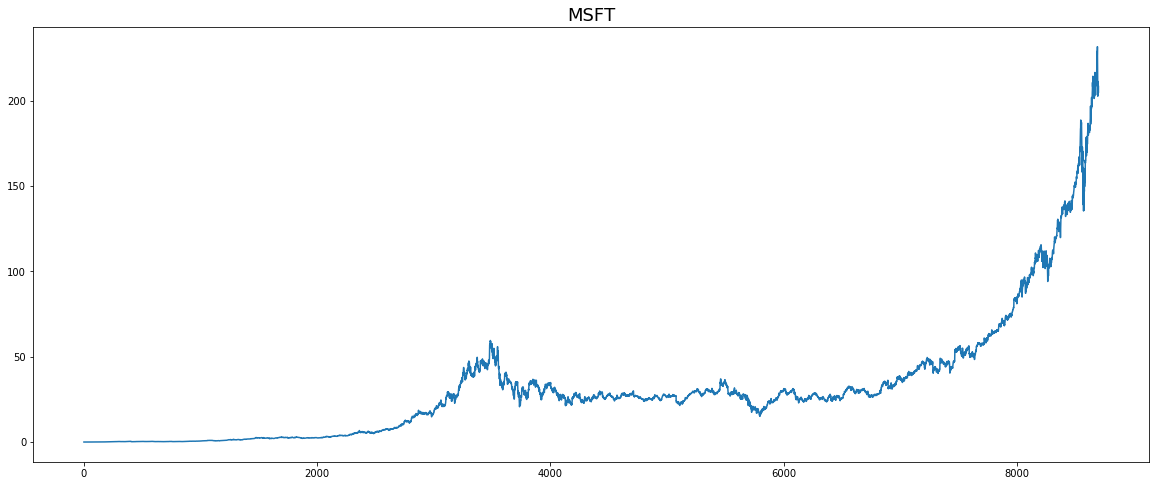

In [34]:
plt.figure(figsize = (20, 8))
plt.plot(data)
plt.title(stock_name  , fontsize = 18)

# Deep Q-Learning algorithm 

In [35]:
class StocksDQN():
    # init functions
    def __init__(self, input_dim, scope, is_eval = False, epsilon_decay_steps = 1000):
        # input_dim: state size
        # is_eval: is being evaluated
        # scope: scope of the model
        self.state_size = input_dim
        self.action_space = 3 # sell, sit, buy
        self.memory = deque(maxlen = 10000)
        self.inventory = [] # holdings that we have
        self.scope = scope # name of scope
        self.is_eval = is_eval # whether in training or deployment
        self.gamma = 0.99 # discount factor
        self.h1_size = 64
        self.h2_size = 32
        self.h3_size = 8
        # epsilon greedy policy
        self.epsilon = 1.0
        self.epsilon_end = 0.01
        self.epsilon_decay_val = (self.epsilon - self.epsilon_end)/epsilon_decay_steps
        self._build_model()
        self.initialize_network()

    def _build_model(self):
        
        self.input_placeholder = tf.placeholder(tf.float32, [None, self.state_size], name = 'inputs')
        self.target_placeholder = tf.placeholder(tf.float32, [None, self.action_space], name = 'target_value')

        # layers
        h1 = tf.contrib.layers.fully_connected(self.input_placeholder, self.h1_size)
        h2 = tf.contrib.layers.fully_connected(h1, self.h2_size)
        h3 = tf.contrib.layers.fully_connected(h2, self.h3_size)
        self.action_pred = tf.contrib.layers.fully_connected(h3, self.action_space,activation_fn = tf.nn.softmax)
        self.loss = tf.reduce_mean(tf.square(self.target_placeholder - self.action_pred))
        self.update_step = tf.train.AdamOptimizer(0.001).minimize(self.loss)
        

    # Initialize the network
    def initialize_network(self):
        self.sess = tf.Session(config=config)
        self.sess.run(tf.global_variables_initializer())

    # Functions for taking actions using epsilon greedy policy
    def act(self, state):
        if not self.is_eval and np.random.random() <= self.epsilon:
            return np.random.randint(self.action_space)

        # else use the model to predict action
        action_dist = self.sess.run(self.action_pred, feed_dict = {self.input_placeholder: state})
        return np.argmax(action_dist[0])

    def experience_replay(self, batch_size):
        mini_batch = []
        mem_len = len(self.memory)
        for i in range(mem_len - batch_size + 1, mem_len):
            mini_batch.append(self.memory[i])
            
        loss_log = []

        for state, action, reward, next_state, done in mini_batch:
            target_s = reward
            if not done:
                # get predictions from model
                pred = self.sess.run(self.action_pred, feed_dict = {self.input_placeholder: next_state})

                # get the target value to be fit
                target_s = reward + self.gamma*np.amax(pred[0])

            # target value to be fit upon
            target_y = self.sess.run(self.action_pred, feed_dict = {self.input_placeholder: state})
            target_y[0][action] = target_s

            # train the model
            feed_dict = {self.input_placeholder: state, self.target_placeholder: target_y}
            loss, _ = self.sess.run([self.loss, self.update_step], feed_dict = feed_dict)

            # add to logs
            loss_log.append(loss)

        # reduce the value of epsilon
        if self.epsilon > self.epsilon_end:
            self.epsilon -= self.epsilon_decay_val

        # return loss
        return loss_log

### To get price of profit, stock prices according to window size

Below is the code for some helper functions

In [36]:
# function to properly return the string of price
def format_price(price):
    return ("-$" if price < 0 else "$") + "{0:.2f}".format(abs(price))

def sigmoid(x):
    return 1/(1 + np.exp(-x))

# function to get the state
def get_state(data, t, n):
    d = t - n + 1
    if d >= 0:
        block = data[d:t+1]
    else:
        # pad with t0
        block = -d*[data[0]] + data[0:t+1].tolist()
    
    # get results
    res = []
    for i in range(n - 1):
        res.append(sigmoid(block[i + 1] - block[i]))
    
    # return numpy array
    return np.array([res])

In [37]:
# define the agent
agent = StocksDQN(window_size, 'model_pre')

In [38]:
# run things
for e in range(episode_count):
    state = get_state(data, 0, window_size + 1)

    # init values for new episode
    total_profit = 0.0 # total profit in this epoch
    agent.inventory = [] # reset the inventory
    total_loss = [] # at each step what was the total loss
    mean_loss = [] # at each step what was the mean loss

    for t in tqdm(range(len_data)):
        action = agent.act(state)

        # next state
        next_state = get_state(data, t + 1, window_size + 1)
        reward = 0

        # now go according to actions
        if action == 2:
            # buy
            agent.inventory.append(data[t])
            if LOG:
                print('Buy:' + format_price(data[t]))


        elif action == 0 and len(agent.inventory) > 0:
            bought_price = agent.inventory.pop(0) # remove the first element and return the value
            profit = data[t] - bought_price # profit this iteration
            reward = max(data[t] - bought_price, 0) # reward
            total_profit += profit # add to total profit
            if LOG:
                print("Sell: " + format_price(data[t]) + " | Profit: " + format_price(profit))

        # condition for finish
        done = t == len_data - 1
        agent.memory.append((state, action, reward, next_state, done))
        state = next_state

        if done and LOG:
            print("Total Profit: " + format_price(total_profit))

        # train the model
        if len(agent.memory) > batch_size:
            losses = agent.experience_replay(batch_size)
            total_loss.append(np.sum(losses))
            mean_loss.append(np.mean(losses))

    # add the mean loss to global loss
    loss_global.append(np.mean(mean_loss))
    profits_global.append(total_profit)
    
    print('[*]Episode: {0}, loss: {1}, profits: {2}'.format(e, loss_global[-1], profits_global[-1]))

100%|██████████| 8699/8699 [01:23<00:00, 104.69it/s][*]Episode: 14, loss: 0.007000233046710491, profits: 60.271384000000005



Text(0, 0.5, 'Profit(dollars)')

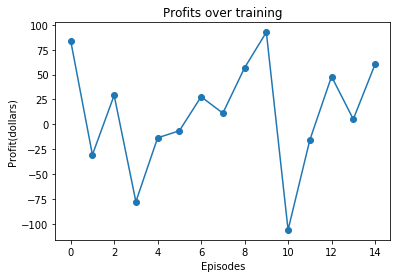

In [39]:
plt.title('Profits over training')
plt.plot(profits_global, '-o')
plt.xlabel('Episodes')
plt.ylabel('Profit(dollars)')

## Double Q learning (with target network)


In [40]:
# functions to copy parameters between two networks
def copy_parameters(q_network, target_network, sess):
    # q_network (source) to target_network (target)
    # sess: tensorflow session
    
    # source
    source_params = [t for t in tf.trainable_variables() if t.name.startswith(q_network.scope)]
    source_params = sorted(source_params, key = lambda v: v.name)
    
    # target
    target_params = [t for t in tf.trainable_variables() if t.name.startswith(target_network.scope)]
    target_params = sorted(target_params, key = lambda v: v.name)
    
    # do assign operations in loop
    for s_v, t_v in zip(source_params, target_params):
        op = t_v.assign(s_v)
        sess.run(op)

In [41]:
class DoubleDQN():
    # initialization function
    def __init__(self, input_dim, scope, is_eval = False):
        self.state_size = input_dim
        self.action_space = 3 # sell, sit, buy
        self.scope = scope # name of scope
        self.h1_size = 64
        self.h2_size = 32
        self.h3_size = 8
        self._build_model()


    def _build_model(self):

        self.input_placeholder = tf.placeholder(tf.float32, [None, self.state_size], name = 'inputs')
        self.q_placeholder = tf.placeholder(tf.float32, [None, self.action_space], name = 'q_value')
        # layers
        h1 = tf.contrib.layers.fully_connected(self.input_placeholder, self.h1_size)
        h2 = tf.contrib.layers.fully_connected(h1, self.h2_size)
        h3 = tf.contrib.layers.fully_connected(h2, self.h3_size)
        self.action_pred = tf.contrib.layers.fully_connected(h3, self.action_space, activation_fn = tf.nn.softmax)
        self.loss = tf.reduce_mean(tf.square(self.q_placeholder - self.action_pred))
        self.update_step = tf.train.AdamOptimizer(0.001).minimize(self.loss)
    
    

In [42]:
def train_dqn(q_network,
              target_network,
              sess,
              data,
              max_mem_size = 750,
              num_episodes = 15,
              train_target_every = 10,
              gamma = 0.99,
              epsilon_start = 0.99,
              epsilon_end = 0.001,
              epsilon_decay = 0.995):
    # function variables
    train_global_step = 0 # global step needed in parameter update
    train_loss = [] # training loss in each episode
    train_profits = [] # for profits in each episode
    
    # memory_buffer
    memory_buffer = []
    
    # initialize variables
    sess.run(tf.global_variables_initializer())
    
    # init stuff
    epsilon = epsilon_start
    
    # iterate over each episode
    for ep in range(num_episodes):
        # for each training episode
        state = get_state(data, 0, window_size + 1)
        
        # init values for new episode
        total_profit = 0.0 # total profit in this episode
        # q_network.inventory = [] # holdings by q_network
        inventory = [] # inventory for this episode
        ep_loss = [] # total loss in this episode
        
        for t in tqdm(range(len_data)):
            # take action according to epsilon greedy policy
            if np.random.random() > epsilon:
                action = np.random.randint(q_network.action_space)
            else:
                feed_dict = {q_network.input_placeholder: state}
                action = sess.run(q_network.action_pred, feed_dict = feed_dict)
                action = np.argmax(action[0])
            
            # next state
            next_state = get_state(data, t + 1, window_size + 1)
            reward = 0
            
            # now go according to the actions
            if action == 2:
                # buy
                inventory.append(data[t])
                if LOG:
                    print('Buy:' + format_price(data[t]))
                    
            elif action == 0 and len(inventory) > 0:
                bought_price = inventory.pop(0) # remove the first element and return the value
                profit = data[t] - bought_price # profit this transaction
                reward = max(data[t] - bought_price, 0) # reward
                total_profit += profit # add to total profit
                if LOG:
                    print("Sell: " + format_price(data[t]) + " | Profit: " + format_price(profit))
                    
            # condition for done
            done = t == len_data - 1
            
            # add to memory and make sure it's of fixed size
            memory_buffer.append((state, action, reward, next_state, done))
            if len(memory_buffer) > max_mem_size:
                memory_buffer.pop(0)
            
            # update state
            state = next_state
            
            # train the model
            if len(memory_buffer) > batch_size:
                
                # sample minibatches here
                mini_batch = memory_buffer[-batch_size:]
                    
                # calculate q_value and target_values
                for state_t, action_t, reward_t, next_state_t, done_t in mini_batch:
                    # condition for calculating y_j
                    if done_t:
                        target_pred = reward
                    
                    else:
                        feed_dict = {target_network.input_placeholder: next_state_t}
                        target_pred = sess.run(target_network.action_pred, feed_dict = feed_dict)
                        target_value = reward_t + gamma*np.amax(target_pred[0])
                    
                    # q_value
                    feed_dict = {q_network.input_placeholder: state_t}
                    q_values = sess.run(q_network.action_pred, feed_dict = feed_dict)
                    q_values[0][action_t] = target_value
                    
                    # drop epsilon value after every action taken
                    if epsilon > epsilon_end:
                        epsilon *= epsilon_decay
                    
                    # update the q_network parameters
                    feed_dict = {q_network.input_placeholder: state_t,
                                 q_network.q_placeholder: q_values}
                    loss, _ = sess.run([q_network.loss, q_network.update_step], feed_dict = feed_dict)
                    
                    # update the lists
                    ep_loss.append(loss)
                    
                    # update target network
                    train_global_step += 1
                    if ep % train_target_every == 0:
                        copy_parameters(q_network, target_network, sess)
                        
        # update the outer values
        train_loss.append(ep_loss)
        train_profits.append(total_profit)
        
        # print val
        print('[*]Episode: {0}, loss: {1}, profits: {2}, epsilon: {3}'\
              .format(ep + 1, np.mean(train_loss[-1]), train_profits[-1], epsilon))
    
    # return the values
    return train_loss, train_profits

In [43]:
# run the model
q_network = DoubleDQN(window_size, 'q_network')
target_network = DoubleDQN( window_size, 'target_network')
sess = tf.Session(config=config)
loss, profits = train_dqn(q_network, target_network, sess, data)

100%|██████████| 8699/8699 [01:39<00:00, 87.76it/s]
[*]Episode: 15, loss: 1.5041004419326782, profits: 2519.489125999999, epsilon: 0.0009954452565571535


Text(0, 0.5, 'Profit(dollars)')

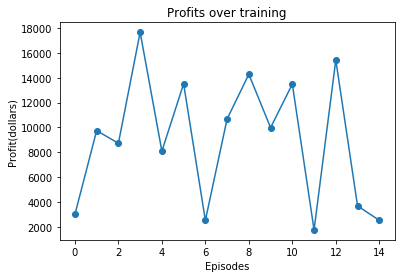

In [44]:
plt.title('Profits over training')
plt.plot(profits, '-o')
plt.xlabel('Episodes')
plt.ylabel('Profit(dollars)')

## Dueling DQN

In [45]:
class DDQN():
    def __init__(self, input_dim, scope):
        self.state_size = input_dim
        self.scope = scope
        self.action_space = 3
        
        # placeholders
        self.input_placeholder = tf.placeholder(tf.float32, [None, self.state_size], name = 'inputs')
        self.q_placeholder = tf.placeholder(tf.float32, [None, self.action_space], name = 'q_value')
        
        # build model
        self._build_model()
        self._build_loss()
        
    def _build_model(self):
        # layers
        h1 = tf.contrib.layers.fully_connected(self.input_placeholder, 64)
        common_h2 = tf.contrib.layers.fully_connected(h1, 32)
        
        # value network layers
        val_h3 = tf.contrib.layers.fully_connected(common_h2, 8)
        self.value = tf.contrib.layers.fully_connected(val_h3, 1)
        
        # advantage network layers
        adv_h3 = tf.contrib.layers.fully_connected(common_h2, 16)
        self.advantage = tf.contrib.layers.fully_connected(adv_h3, self.action_space)
        
        # get the final q value
        # tensorflow automatically perform the calculation of type [1,1] + [1,3] = [1,3]
        # Q(s,a) = V(s) + (A(s,a) - 1/|A|(sum(A(s,a))))
        self.action_pred = self.value + (self.advantage - tf.reduce_mean(self.advantage, axis = 1, keepdims = True)) 
        
    def _build_loss(self):
        self.loss = tf.reduce_mean(tf.square(self.action_pred - self.q_placeholder))
        self.train_step = tf.train.AdamOptimizer().minimize(self.loss)


In [47]:
def train_ddqn(network,
               sess,
               data,
               max_mem_size = 1000,
               num_episodes = 15,
               gamma = 0.99,
               epsilon_start = 0.99,
               epsilon_end = 0.001,
               epsilon_decay = 0.995):
    # function variables
    train_global_step = 0 # global step needed in parameter update
    train_loss = [] # training loss in each episode
    train_profits = [] # for profits in each episode
    
    # memory_buffer
    memory_buffer = []
    
    # initialize variables
    sess.run(tf.global_variables_initializer())
    
    # init stuff
    epsilon = epsilon_start
    
    # iterate over each episode
    for ep in range(num_episodes):
        # for each training episode
        state = get_state(data, 0, window_size + 1)
        
        # init values for new episode
        total_profit = 0.0 # total profit in this episode
        # q_network.inventory = [] # holdings by q_network
        inventory = [] # inventory for this episode
        ep_loss = [] # total loss in this episode
        
        for t in tqdm(range(len_data)):
            # take action according to epsilon greedy policy
            if np.random.random() > epsilon:
                action = np.random.randint(q_network.action_space)
            else:
                feed_dict = {q_network.input_placeholder: state}
                action = sess.run(q_network.action_pred, feed_dict = feed_dict)
                action = np.argmax(action[0])
            
            # next state
            next_state = get_state(data, t + 1, window_size + 1)
            reward = 0
            
            # now go according to the actions
            if action == 2:
                # buy
                inventory.append(data[t])
                if LOG:
                    print('Buy:' + format_price(data[t]))
                    
            elif action == 0 and len(inventory) > 0:
                bought_price = inventory.pop(0) # remove the first element and return the value
                profit = data[t] - bought_price # profit this transaction
                reward = max(data[t] - bought_price, 0) # reward
                total_profit += profit # add to total profit
                if LOG:
                    print("Sell: " + format_price(data[t]) + " | Profit: " + format_price(profit))
                    
            # condition for done
            done = t == len_data - 1
            
            # add to memory and make sure it's of fixed size
            memory_buffer.append((state, action, reward, next_state, done))
            if len(memory_buffer) > max_mem_size:
                memory_buffer.pop(0)
            
            # update state
            state = next_state
            
            # train the model
            if len(memory_buffer) > batch_size:
                
                # sample minibatches here
                mini_batch = memory_buffer[-batch_size:]
                    
                # calculate q_value and target_values
                for state_t, action_t, reward_t, next_state_t, done_t in mini_batch:
                    # condition for calculating y_j
                    if done_t:
                        target_pred = reward
                    
                    else:
                        feed_dict = {network.input_placeholder: next_state_t}
                        network_pred = sess.run(network.action_pred, feed_dict = feed_dict)
                        target_value = reward_t + gamma*np.amax(network_pred[0])
                    
                    # q_value
                    feed_dict = {network.input_placeholder: state_t}
                    q_values = sess.run(network.action_pred, feed_dict = feed_dict)
                    q_values[0][action_t] = target_value
                    
                    # drop epsilon value after every action taken
                    if epsilon > epsilon_end:
                        epsilon *= epsilon_decay
                    
                    # update the q_network parameters
                    feed_dict = {network.input_placeholder: state_t,
                                 network.q_placeholder: q_values}
                    loss, _ = sess.run([q_network.loss, q_network.train_step], feed_dict = feed_dict)
                    
                    # update the lists
                    ep_loss.append(loss)
                    
        # update the outer values
        train_loss.append(ep_loss)
        train_profits.append(total_profit)
        
        # print val
        print('[*]Episode: {0}, loss: {1}, profits: {2}, epsilon: {3}'\
              .format(ep + 1, np.mean(train_loss[-1]), train_profits[-1], epsilon))
    
    # return the values
    return train_loss, train_profits

In [48]:
# run the model
q_network = DDQN(window_size, 'q_network')
sess = tf.Session(config=config)
loss, profits = train_ddqn(q_network, sess, data)

100%|██████████| 8699/8699 [01:34<00:00, 91.61it/s] 
[*]Episode: 15, loss: 12.265534400939941, profits: 9973.962029000008, epsilon: 0.0009954452565571535


Text(0, 0.5, 'Profit(dollars)')

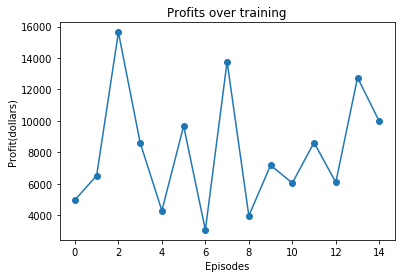

In [49]:
plt.title('Profits over training')
plt.plot(profits, '-o')
plt.xlabel('Episodes')
plt.ylabel('Profit(dollars)')

## Conclusions

- Both Dueling DQN and Double DQN give better profits than vanilla DQN.
- Although more tuning is neccessary better predictions.
- Algorithms perform better for the companies which have good and bad phases in the stock market.
- This can be explained because agent can learn all possible scenarios - good and bad stock rate in the market.